In [1]:
import jtap_mice
jtap_mice.set_jaxcache()
from jtap_mice.inference import run_jtap, run_parallel_jtap, JTAPMiceData
from jtap_mice.viz import rerun_jtap_stimulus, rerun_jtap_single_run, jtap_plot_lr_lines, red_green_viz_notebook, plot_proposal_direction_outlier_pdf, draw_stimulus_image
from jtap_mice.utils import load_left_right_stimulus, JTAPMiceStimulus, ChexModelInput, d2r, i_, f_, slice_pt, init_step_concat, discrete_obs_to_rgb, stack_pytrees, concat_pytrees
from jtap_mice.evaluation import jtap_compute_beliefs, JTAPMice_Beliefs

import time
import rerun as rr
import genjax
from genjax import gen, ChoiceMapBuilder as C
import jax
import jax.numpy as jnp
from jax.debug import print as jprint
import numpy as np
from tqdm import tqdm
import jax.tree_util as jtu
from functools import partial
from matplotlib import pyplot as plt
from typing import List, Dict, Any, Tuple, NamedTuple

PIXEL_DENSITY = 10
SKIP_T = 4

In [2]:
LR_CONFIG= 'lr_v1'
LR_TRIAL = 1

stimulus_path = f'/home/arijitdasgupta/jtap-mice/notebooks/left_right_task/{LR_CONFIG}.json'

jtap_stimulus = load_left_right_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY, skip_t = SKIP_T, trial_number = LR_TRIAL)

rgb_video_highres = load_left_right_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY*5, skip_t = SKIP_T, rgb_only = True, trial_number = LR_TRIAL)

In [ ]:
rerun_jtap_stimulus(discrete_obs = jtap_stimulus.discrete_obs, stimulus_name = "rg_stim1_discrete")

In [12]:
# Parameters based on default values in ChexModelInput @datastrucs.py

model_direction_flip_prob = 0.025
simulation_direction_flip_prob = 0.025
proposal_direction_flip_prob = 0.025

σ_pos_model=0.5
σ_pos_simulation=0.05
σ_pos_stepprop = 0.01

σ_speed_model=0.075
σ_speed_simulation=0.075
σ_speed_stepprop = 0.01

Model_Input = ChexModelInput(
    model_outlier_prob = 0.00,
    proposal_direction_outlier_tau = d2r(40.),
    proposal_direction_outlier_alpha = 3.5,
    σ_pos_model=σ_pos_model,
    σ_speed_model=σ_speed_model,
    model_direction_flip_prob=model_direction_flip_prob,
    pixel_corruption_prob=0.01,
    tile_size=3,
    σ_pixel_spatial=1.0,
    image_power_beta=0.005,
    max_speed=1.0,
    max_num_occ=5,
    num_x_grid=8,
    grid_size_bounds=(0.05, 0.95),
    simulate_every=1,
    σ_pos_simulation=σ_pos_simulation,
    σ_speed_simulation=σ_speed_simulation,
    simulation_direction_flip_prob=simulation_direction_flip_prob,
    σ_pos_initprop=0.02,
    proposal_direction_flip_prob=proposal_direction_flip_prob,#direction_flip_prob,
    σ_speed_stepprop=σ_speed_stepprop,
    σ_pos_stepprop=σ_pos_stepprop
)
# PREPARE INPUT
Model_Input.prepare_hyperparameters()
Model_Input.prepare_scene_geometry(jtap_stimulus)

ESS_proportion = 0.0
smc_key_seed = np.random.randint(0, 1000000)
num_particles = 50

In [13]:
num_jtap_runs = 50

start_time = time.time()
JTAPMICE_DATA, xx = run_parallel_jtap(num_jtap_runs, smc_key_seed, Model_Input, ESS_proportion, jtap_stimulus, num_particles)
end_time = time.time()
mean_ESS = np.mean(JTAPMICE_DATA.inference.ESS.mean(axis=1))
print(f"Mean ESS: {100 * mean_ESS / num_particles:.1f}% of {num_particles} particles")
resampled = JTAPMICE_DATA.inference.resampled
resampled_pct = 100 * np.mean(resampled)
print(f"Resampling occurred in {resampled_pct:.1f}% of {jtap_stimulus.num_frames} frames")
print(f"Time taken for parallel JTAP: {end_time - start_time} seconds")

Mean ESS: 7.1% of 50 particles
Resampling occurred in 0.0% of 46 frames
Time taken for parallel JTAP: 0.1496572494506836 seconds


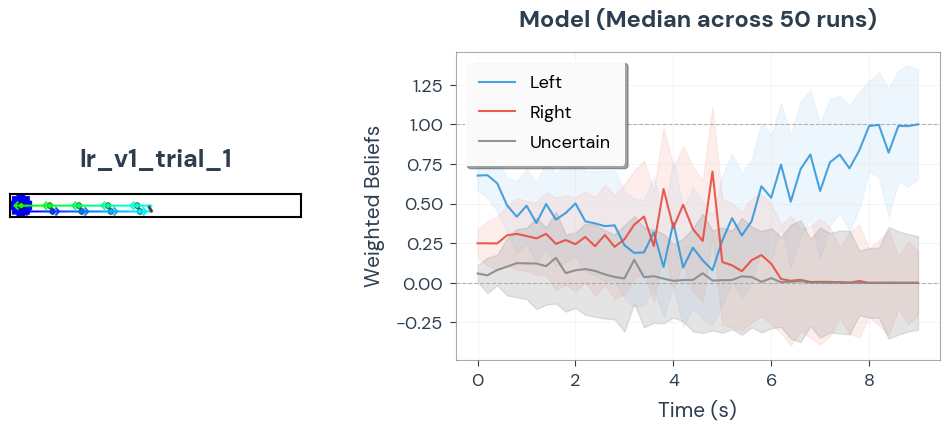

In [14]:
JTAPMice_Beliefs = jtap_compute_beliefs(JTAPMICE_DATA)
jtap_run_idx = None
show_all_lines = False
show_std_band = True
jtap_plot_lr_lines(lr_beliefs = JTAPMice_Beliefs, stimulus = jtap_stimulus, show = "model", include_baselines=False, remove_legend=False, show_std_band=show_std_band, jtap_run_idx = jtap_run_idx, include_start_frame=True, show_all_beliefs=show_all_lines, plot_stat = "median", include_stimulus=True)

In [ ]:
red_green_viz_notebook(JTAPMICE_DATA, viz_key = jax.random.PRNGKey(0), prediction_t_offset = None, video_offset = (0,0),
    fps = 10, skip_t = 1, show_latents = True, min_dot_alpha = 0.2, min_line_alpha = 0.04, show_resampled_text = True, num_t_steps = None, diameter = 1.0)

In [9]:
jtap_run_idx_viz = 9

rerun_jtap_single_run(JTAPMICE_DATA, rgb_video_highres = None, stimulus_name = "jtap_single_runv3", tracking_dot_size_range = (0.5,2), prediction_line_size_range = (0.05,0.4), jtap_run_idx = jtap_run_idx_viz, grid_dot_radius = 0.3, render_grid = True, show_velocity = True)

In [ ]:
slice_pt(JTAPMICE_DATA.step_prop_retvals,1)

In [10]:
slice_pt(JTAPMICE_DATA.inference,1).prediction

PredictionData(x=array([[[ 0.15724194,  0.25804728,  0.394736  , ...,  0.7568632 ,
          0.17927977,  0.02374806],
        [ 0.31119153,  0.4330535 ,  0.72365963, ...,  1.3649434 ,
          0.19405624, -0.03469222],
        [ 0.35243878,  0.6114978 ,  1.0664537 , ...,  2.1639311 ,
          0.2541098 , -0.26415348],
        ...,
        [ 7.7740417 , 13.        , 13.        , ..., 13.        ,
          6.1510386 , -1.        ],
        [ 7.987913  , 13.        , 13.        , ..., 13.        ,
          6.269797  , -1.        ],
        [ 8.163786  , 13.        , 13.        , ..., 13.        ,
          6.5222096 , -1.        ]],

       [[ 0.5560036 ,  0.5171279 ,  0.72776616, ...,  1.0618567 ,
          0.4996268 ,  0.33839235],
        [ 0.6760058 ,  0.6906205 ,  0.9250964 , ...,  1.7130983 ,
          0.6230662 ,  0.24987297],
        [ 0.7475392 ,  0.8350662 ,  1.279181  , ...,  2.5549886 ,
          0.8184239 ,  0.17796767],
        ...,
        [10.337273  , 13.        , 12.994568  , ..., 12.989041  ,
         12.998224  , -0.99999994],
        [10.695446  , 13.        , 12.963185  , ..., 12.958045  ,
         12.998834  , -0.99999994],
        [10.91605   , 13.        , 12.963601  , ..., 12.97223   ,
         12.998273  , -0.9999999 ]],

       [[ 0.8089002 ,  0.74371845,  0.9131393 , ...,  1.2578572 ,
          0.8268859 ,  0.5636401 ],
        [ 1.0645373 ,  0.8511629 ,  1.2868621 , ...,  2.0074534 ,
          0.8993133 ,  0.59002745],
        [ 1.1719221 ,  0.93771845,  1.5849785 , ...,  2.6454263 ,
          0.9957239 ,  0.54411185],
        ...,
        [13.        , 13.        , 13.        , ..., 13.        ,
         12.989918  , -0.99999994],
        [13.        , 12.991802  , 13.        , ..., 12.999356  ,
         12.990358  , -0.99999994],
        [13.        , 13.        , 13.        , ..., 13.        ,
         12.986291  , -0.99999994]],

       ...,

       [[ 0.7154634 ,  0.7202571 ,  0.85940504, ...,  1.1493862 ,
          0.7082144 ,  0.41225722],
        [ 0.84008473,  0.8774643 ,  1.3900121 , ...,  1.8346399 ,
          0.7990335 ,  0.33257478],
        [ 0.929244  ,  1.0231036 ,  1.7992668 , ...,  2.5473049 ,
          0.7618529 ,  0.03692869],
        ...,
        [12.067225  , 13.        ,  7.914101  , ..., 13.        ,
         13.        , -1.        ],
        [12.077624  , 12.997372  ,  8.023646  , ..., 13.        ,
         13.        , -1.        ],
        [12.1641865 , 13.        ,  8.073503  , ..., 13.        ,
         13.        , -1.        ]],

       [[ 0.34909105,  0.36338824,  0.5163697 , ...,  0.8067318 ,
          0.25100374,  0.15138645],
        [ 0.530397  ,  0.5494174 ,  0.88828677, ...,  1.4647915 ,
          0.24811067,  0.12498476],
        [ 0.6596849 ,  0.7888749 ,  1.2361779 , ...,  2.2622933 ,
          0.4522961 ,  0.06701973],
        ...,
        [ 7.5106874 , 13.        , 13.        , ..., 13.        ,
         13.        , -0.99999994],
        [ 7.8333573 , 13.        , 13.        , ..., 13.        ,
         13.        , -0.99999994],
        [ 8.226234  , 13.        , 13.        , ..., 13.        ,
         13.        , -0.99999994]],

       [[ 0.21017687,  0.21177036,  0.28694305, ...,  0.6793536 ,
          0.20593415, -0.04417797],
        [ 0.50835437,  0.29695776,  0.64905065, ...,  1.3899279 ,
          0.40572727, -0.15779276],
        [ 0.9202733 ,  0.4034114 ,  0.9811301 , ...,  1.9782183 ,
          0.64570194, -0.14278755],
        ...,
        [ 8.540916  , 12.978499  , 12.364788  , ..., 12.918904  ,
         13.        , -0.99999994],
        [ 8.712278  , 12.887666  , 12.67683   , ..., 12.929544  ,
         13.        , -0.99999994],
        [ 8.932376  , 12.967968  , 12.951693  , ..., 12.984417  ,
         13.        , -0.99999994]]], dtype=float32), y=array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., 

In [6]:
slice_pt(JTAPMICE_DATA.inference,1).prediction.x[...,3]

array([[-0.60191077, -1.        , -0.99999994, ..., -0.99999994,
        -0.9999999 , -0.9999999 ],
       [-0.31348076, -0.98623514, -0.99999994, ..., -0.99999994,
        -0.99999994, -0.99999994],
       [-0.10580793, -0.8789809 , -0.99999994, ..., -0.9999999 ,
        -0.99999994, -0.99999994],
       ...,
       [-0.15277356, -0.88865185, -0.99999994, ..., -0.99999994,
        -0.99999994, -0.99999994],
       [-0.5315008 , -0.99440557, -0.99999994, ..., -0.99999994,
        -1.        , -0.99999994],
       [-0.69066346, -0.99999994, -0.9999999 , ..., -0.9999998 ,
        -0.99999994, -0.99999994]], dtype=float32)

In [ ]:
key = jax.random.PRNGKey(np.random.randint(0, 1000000))
genjax.truncated_normal.sample(key, jnp.array([1.5]), jnp.array([100.0]), jnp.array([0.0]), jnp.array([1.0]))